In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt    
from sklearn.model_selection import train_test_split

In [2]:
def create_ts_dataset(
                data_path='data/Smart Consumption.csv',
                sel_window = 30,
                pred_window = 1
                ):
        df = pd.read_csv(data_path)
        df['Timestamp'] = pd.to_datetime(df['Timestamp'])
        del df['Timestamp']

        X, Y = [], []
        for i in range(len(df) - sel_window - pred_window):
                data = df.iloc[i:i+sel_window]
                target = df[['Fridge_kWh','AC_kWh','Light_kWh']].iloc[i+sel_window:i+sel_window+pred_window]
                X.append(data.values)
                Y.append(target.values)

        X = np.array(X)
        Y = np.array(Y).squeeze()

        return X, Y

In [3]:
X, Y = create_ts_dataset()
print(f"X shape: {X.shape}\nY shape: {Y.shape}")

X shape: (2526, 30, 5)
Y shape: (2526, 3)


In [4]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(
                                                X, Y, 
                                                test_size=0.15, 
                                                random_state=42
                                                )

In [5]:
cnn_model = tf.keras.models.Sequential([
                                        tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(30, 5)),
                                        tf.keras.layers.MaxPooling1D(pool_size=2),

                                        tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
                                        tf.keras.layers.MaxPooling1D(pool_size=2),
                                        
                                        tf.keras.layers.Dropout(0.5),
                                        tf.keras.layers.Flatten(),
                                        tf.keras.layers.Dense(3)
                                        ])
cnn_model.summary()

/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 28, 32)         │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 14, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 12, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         1,155 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,875 (30.76 KB)

 Trainable params: 7,875 (30.76 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
cnn_model.compile(
                optimizer='adam', 
                metrics=['mae'],
                loss='mse'
                )

In [7]:
history = cnn_model.fit(
                        Xtrain, Ytrain, 
                        epochs=100, batch_size=256, 
                        validation_data=(Xtest, Ytest),
                        callbacks=[
                                tf.keras.callbacks.EarlyStopping(
                                                                patience=100, 
                                                                restore_best_weights=True
                                                                )
                                ]
                        )

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 160.0311 - mae: 9.8850 - val_loss: 9.1308 - val_mae: 2.4001
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 53.5377 - mae: 5.8116 - val_loss: 4.0936 - val_mae: 1.6427
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 20.8877 - mae: 3.6301 - val_loss: 4.3696 - val_mae: 1.6830
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.6149 - mae: 2.4591 - val_loss: 3.1414 - val_mae: 1.4605
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.2498 - mae: 1.8472 - val_loss: 2.6663 - val_mae: 1.3505
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.0582 - mae: 1.6425 - val_loss: 2.5093 - val_mae: 1.3251
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.7854 - mae: 1.5869 - val_loss: 2.4892 - val_mae: 1.3236
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.4736 - mae: 1.5230 - val_loss: 2.4654 - val_mae: 1.3265
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.4524 - mae: 1.52

In [8]:
cnn_model.save('artifacts/smart_consumption.h5')

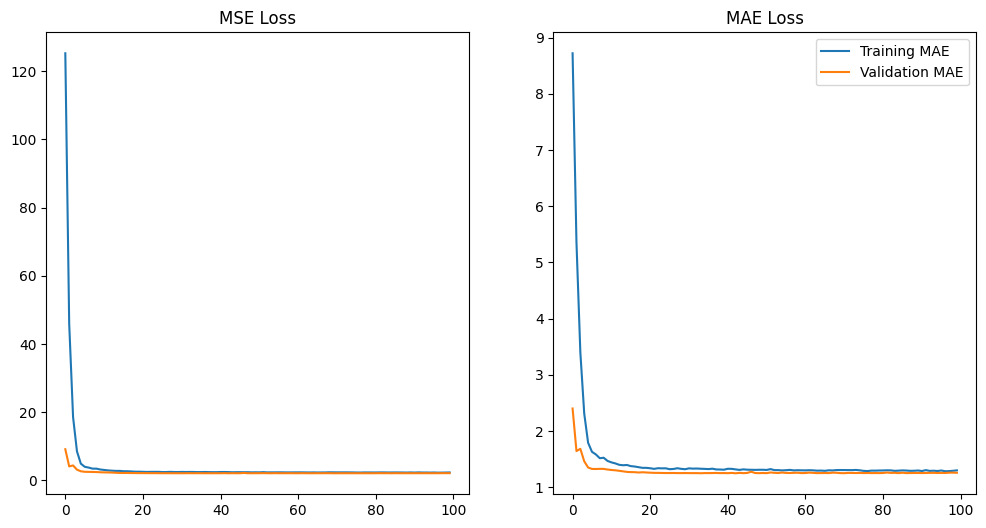

In [9]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training MSE')
plt.plot(history.history['val_loss'], label='Validation MSE')
plt.title('MSE Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE Loss')

plt.legend()
plt.show()

In [10]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [11]:
model_device = tf.keras.models.load_model('artifacts/smart_consumption.h5')
model_device.compile(
                    optimizer='adam', 
                    metrics=['mae'],
                    loss='mse'
                    )

TypeError: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}

In [ ]:
recomendation_json = {
                    "appliances": [
                        {
                        "name": "Fridge",
                        "outcomes": {
                            "Low": {
                            "suggested_action": [
                                "Check if the fridge is not cooling properly.",
                                "Inspect the compressor, door seals, or thermostat settings.",
                                "Consider a power failure or disconnection."
                            ]
                            },
                            "High": {
                            "suggested_action": [
                                "Check for overloading, poor ventilation, or malfunctioning components (e.g., compressor).",
                                "Clean condenser coils and ensure the door is closed tightly.",
                                "If persistent, consult a technician."
                            ]
                            }
                        }
                        },
                        {
                        "name": "AC",
                        "outcomes": {
                            "Low": {
                            "suggested_action": [
                                "Check if the AC is not cooling effectively.",
                                "Inspect for potential refrigerant leaks, a malfunctioning compressor, or blocked filters."
                            ]
                            },
                            "High": {
                            "suggested_action": [
                                "Verify the room size matches the AC capacity.",
                                "Check for dirty filters, poor insulation, or faulty components.",
                                "Ensure the thermostat setting is optimal (e.g., 24°C–26°C)."
                            ]
                            }
                        }
                        },
                        {
                        "name": "Light",
                        "outcomes": {
                            "Low": {
                            "suggested_action": [
                                "Check if the bulb is flickering or malfunctioning.",
                                "Replace the bulb or inspect wiring issues."
                            ]
                            },
                            "High": {
                            "suggested_action": [
                                "Identify if older, inefficient bulbs (e.g., incandescent) are in use.",
                                "Consider replacing them with energy-efficient LED bulbs.",
                                "Inspect for potential short circuits or wiring issues."
                            ]
                            }
                        }
                        }
                    ]
                    }

In [ ]:
def detect_energy_level(consumptions):
    ranges = {
            "Fridge": {"Low": (1, 2), "Normal": (2, 3), "High": (3, 4)},
            "AC": {"Low": (0, 10), "Normal": (10, 15), "High": (15, 25)},
            "Light": {"Low": (0.01, 0.05), "Normal": (0.05, 0.1), "High": (0.1, 0.2)},
            "House": {"Low": (0, 12.05), "Normal": (12.05, 18.1), "High": (18.1, 29.2)}
            }

    appliances = ["Fridge", "AC", "Light"]

    # Initialize dictionary to store levels
    levels = {}

    # Loop over consumptions and determine level for each appliance
    for i, consumption in enumerate(consumptions):
        appliance = appliances[i]
        for level, (low, high) in ranges[appliance].items():
            if low <= consumption <= high:
                levels[appliance] = level
                break
        else:
            if ranges[appliance]["Low"][0] > consumption:
                levels[appliance] = "low"  
            elif ranges[appliance]["High"][1] < consumption:
                levels[appliance] = "high"

    # Calculate total house consumption and determine level
    house_consumption = sum(consumptions)
    for level, (low, high) in ranges["House"].items():
        if low <= house_consumption <= high:
            levels["House"] = level
            break
    else:
        if ranges["House"]["Low"][0] > house_consumption:
            levels["House"] = "low"
        elif ranges["House"]["High"][1] < house_consumption:
            levels["House"] = "high"    

    return levels


def inference_devices(
                    data_path='data/Smart Consumption.csv',
                    sel_window = 30
                    ):
        df = pd.read_csv(data_path)
        df['Timestamp'] = pd.to_datetime(df['Timestamp'])
        del df['Timestamp']

        data = df.iloc[-sel_window:]
        data = np.array([data.values])

        prediction = model_device.predict(data)
        prediction = prediction.squeeze()
        
        levels = detect_energy_level(prediction)
        # levels = {'Fridge': 'Normal', 'AC': 'Low', 'Light': 'high', 'House': 'Low'}

        # add consumption too
        levels_upd = []
        for idx, (key, value) in enumerate(levels.items()):
            if idx < 3:
                data_j = {}
                data_j["Consumption"] = f"{prediction[idx]} kWh"
                data_j["Level"] = value
                if value != "Normal":
                    rec_data = recomendation_json["appliances"][idx]['outcomes'][value.capitalize()]['suggested_action']
                    data_j["Recommendation"] = rec_data

            else:
                data_j = {}
                data_j["Consumption"] = f"{prediction.sum()} kWh"
                data_j["Level"] = value

            levels_upd.append({key: data_j})

        return levels_upd

In [ ]:
inference_devices()

1/1 [==============================] - 0s 195ms/step


[{'Fridge': {'Consumption': '2.3505489826202393 kWh', 'Level': 'Normal'}},
 {'AC': {'Consumption': '2.174177885055542 kWh',
   'Level': 'Low',
   'Recommendation': ['Check if the AC is not cooling effectively.',
    'Inspect for potential refrigerant leaks, a malfunctioning compressor, or blocked filters.']}},
 {'Light': {'Consumption': '2.4468326568603516 kWh',
   'Level': 'high',
   'Recommendation': ['Identify if older, inefficient bulbs (e.g., incandescent) are in use.',
    'Consider replacing them with energy-efficient LED bulbs.',
    'Inspect for potential short circuits or wiring issues.']}},
 {'House': {'Consumption': '6.971559524536133 kWh', 'Level': 'Low'}}]